# 0.0 Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import re

from matplotlib import pyplot as plt

## 0.1 Helper Functions

In [2]:
def descriptive_statistics_num(num_attributes):
    # Central Tendecy (Mean and Median)
    c1 = pd.DataFrame(num_attributes.apply(lambda x: np.mean(x)))
    c2 = pd.DataFrame(num_attributes.apply(lambda x: np.median(x)))

    # Dispersion
    d1 = pd.DataFrame(num_attributes.apply(lambda x: (x).min()))
    d2 = pd.DataFrame(num_attributes.apply(lambda x: (x).max()))
    d3 = pd.DataFrame(num_attributes.apply(lambda x: (x).max() - (x).min()))
    d4 = pd.DataFrame(num_attributes.apply(lambda x: np.std(x)))
    d5 = pd.DataFrame(num_attributes.apply(lambda x: (x).skew()))
    d6 = pd.DataFrame(num_attributes.apply(lambda x: (x).kurtosis()))

    a = pd.concat([d1,d2,d3, c1,c2,d4,d5,d6], axis = 1)
    a.columns = ['min', 'max','range','mean','median','std','skew','kurtosis']
    return a


## 0.2 Loading Dataset

In [3]:
# load data
path = '/home/tiagobarreto/DS/repos/elasticidade_preco/'
df_raw = pd.read_csv(path +'../data/raw/transactions.csv', encoding='latin1')

# drop extra column
df_raw = df_raw.drop('Unnamed: 0', axis = 1)

# 1.0 Descrição dos Dados

In [4]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [5]:
columns = ['Date_imp',
 'Category_name',
 'name',
 'price',
 'merchant',
 'brand',
 'currency',
 'weight']

# Transformando os nomes das colunas para letras minúsculas
columns_lower = [col.lower() for col in columns]

# Atribuindo os novos nomes de colunas ao DataFrame
df1.columns = columns_lower[:len(df1.columns)]

## 1.2 Data Dimensions, Types e NA

In [6]:
df1.shape

(23151, 8)

## 1.3 Datatypes

In [7]:
df1.dtypes

date_imp          object
category_name     object
name              object
price            float64
merchant          object
brand             object
currency          object
weight            object
dtype: object

## 1.4 Check NA

In [8]:
df1.isna().mean()

date_imp         0.000000
category_name    0.000000
name             0.000000
price            0.000000
merchant         0.000000
brand            0.000000
currency         0.000000
weight           0.002937
dtype: float64

## 1.5 Replace NA

## 1.6 Change Datatypes

In [9]:
# date_imp
df1['date_imp'] = pd.to_datetime(df1['date_imp'], format='%Y-%m-%d %H:%M:%S')



# 2.0 Feature Engineering

In [10]:
df2 = df1.copy()

In [11]:
# criando variável mês
df2['month'] = df2['date_imp'].dt.month

# 3.0 EDA

In [12]:
df3 = df2.copy()

## 3.1 Price
- Min e Max extremos.

In [13]:
descriptive_statistics_num(df3.loc[:, ['price']])

,min,max,range,mean,median,std,skew,kurtosis
price,1.0,10879.95,10878.95,513.037803,199.99,859.091448,4.59516,34.411146


## 3.2 Month
- O mês 4 tem poucas transações, vai gerar muitos outliers posteriormente.

<Axes: xlabel='month', ylabel='date_imp'>

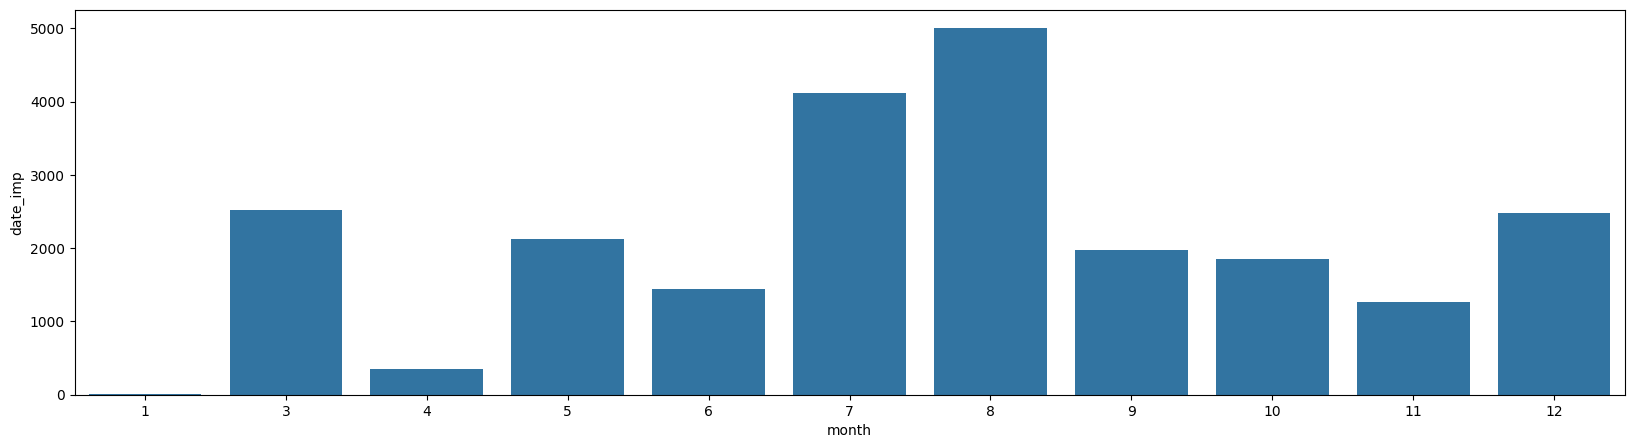

In [14]:
plt.figure(figsize=(20, 5))
df_aux = df3[['month', 'date_imp']].groupby('month').count().reset_index()
sns.barplot(x='month', y='date_imp', data = df_aux)

## 3.3 Merchant
- Bestbuy.com é o merchant com maior volume de transações

<Axes: xlabel='merchant', ylabel='date_imp'>

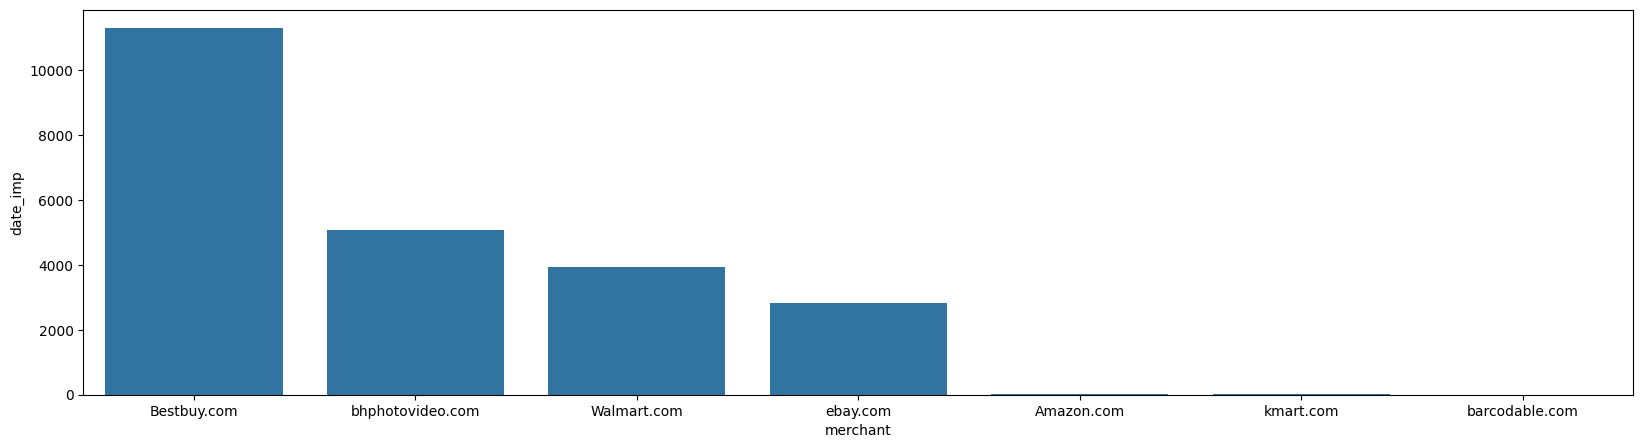

In [15]:
plt.figure(figsize=(20, 5))
df_aux = df3[['merchant', 'date_imp']].groupby('merchant').count().sort_values(by='date_imp', ascending = False).reset_index()
sns.barplot(x='merchant', y='date_imp', data = df_aux)

## 3.4 Marca

([0, 1, 2], [Text(0, 0, 'Sony'), Text(1, 0, 'Apple'), Text(2, 0, 'Yamaha')])

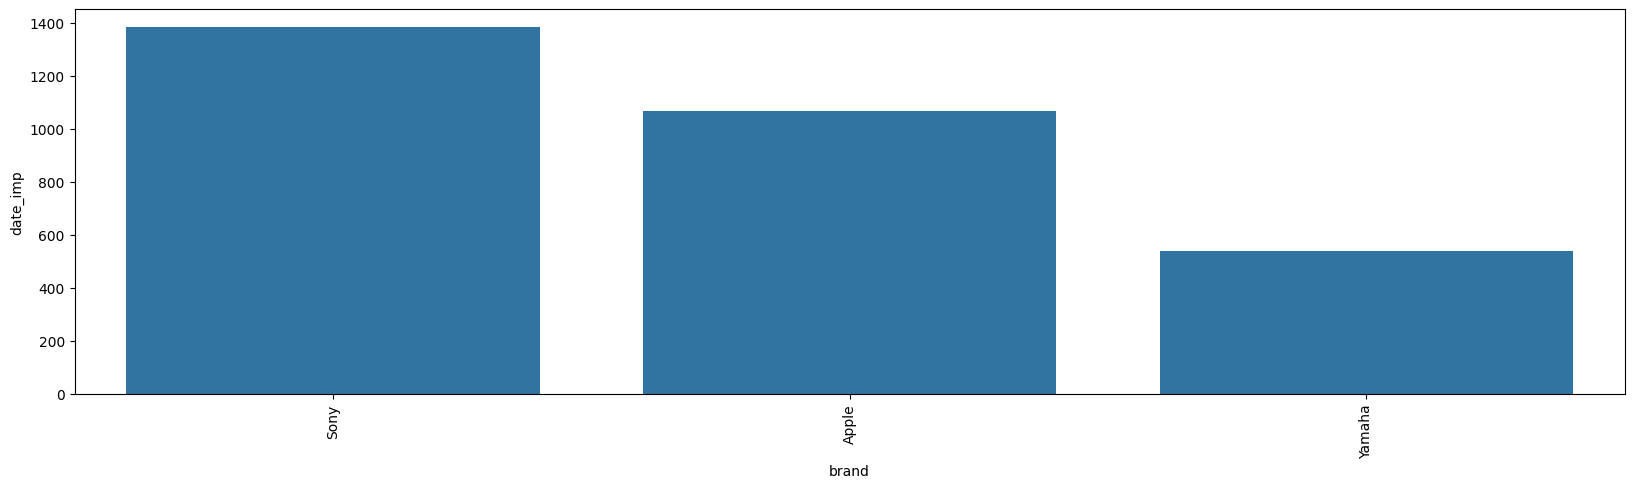

In [16]:
plt.figure(figsize=(20, 5))
df_aux = df3.loc[df3['merchant'] == 'Bestbuy.com' , ['brand', 'date_imp']].groupby('brand').count().sort_values(by='date_imp', ascending = False).head(3).reset_index()

sns.barplot(x='brand', y='date_imp', data = df_aux)
plt.xticks(rotation = 90)

### 3.4.1 Apple
- Vendas a $1.00: Apple MacBook Pro MLUQ2LL/A 13.3 Notebook - Intel Core i5 Dual-core (2 Core) 2 GHz - 8 GB LPDDR3 - 256 GB SSD - Mac OS X 10.12 Sierra - 2560 x 1600
- Vendas a $1.00: Apple 13.3 MacBook Air ( Silver)"

/home/tiagobarreto/.pyenv/versions/3.11.4/envs/elasticidade/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 130 (\x82) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


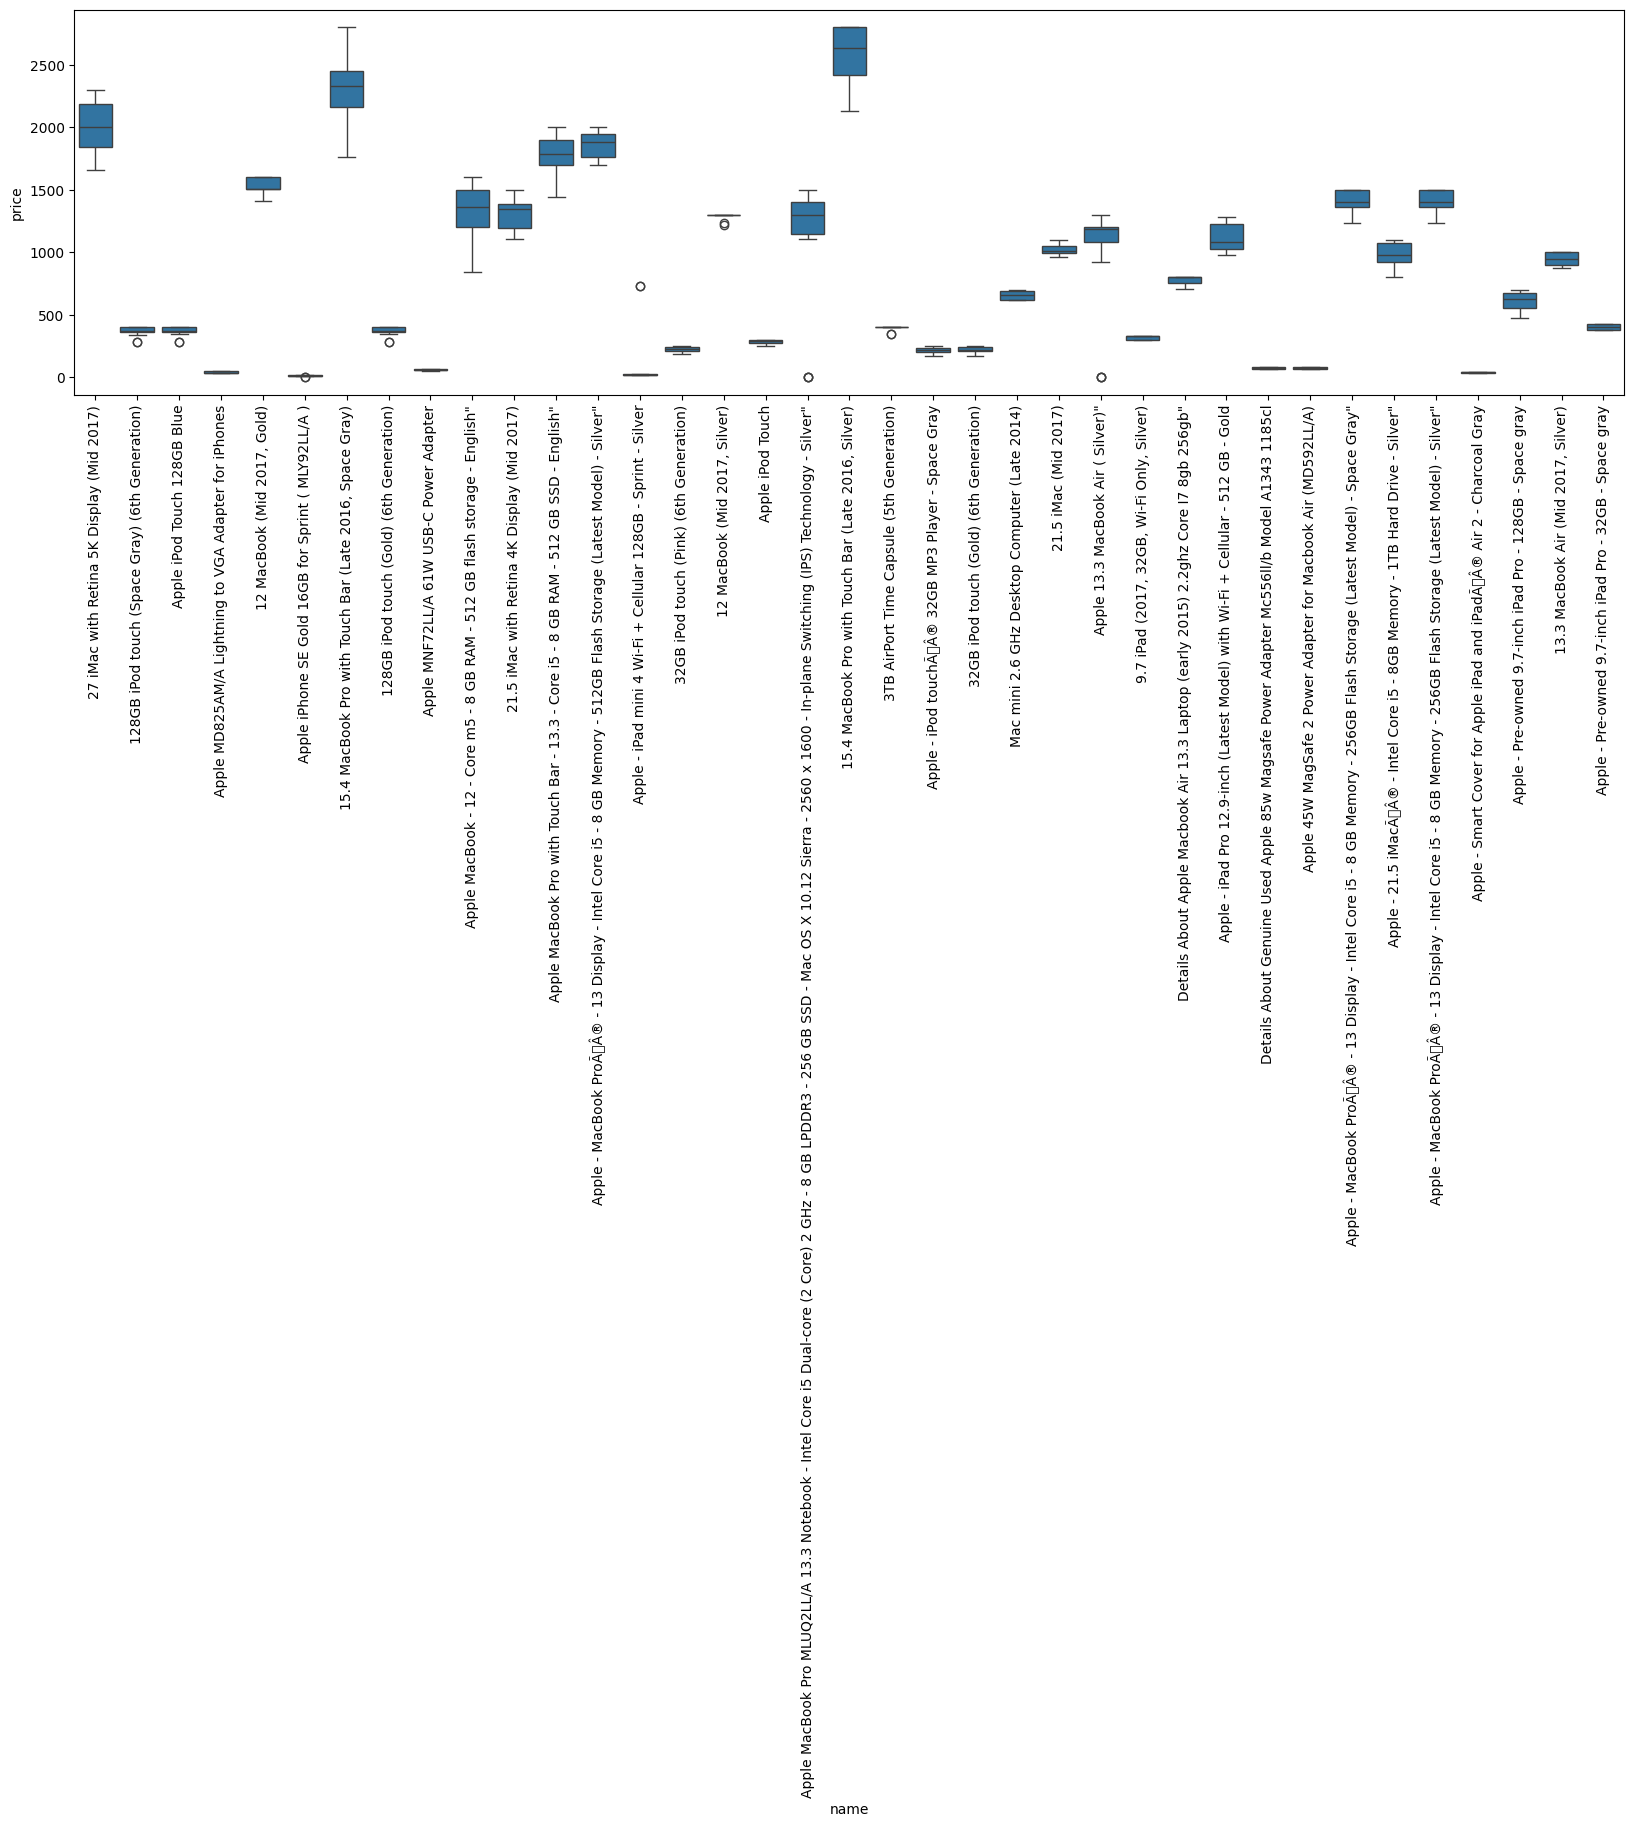

In [17]:
aux = df3.loc[(df3['merchant'] == 'Bestbuy.com') & (df3['brand'] == 'Apple'), ['brand', 'price','name']]

plt.figure(figsize=(20,5))
sns.boxplot(x='name', y='price', data = aux);
plt.xticks(rotation = 90);
plt.show()

In [18]:
## Investigando
# aux[aux['name'] == 'Apple MacBook Pro MLUQ2LL/A 13.3 Notebook - Intel Core i5 Dual-core (2 Core) 2 GHz - 8 GB LPDDR3 - 256 GB SSD - Mac OS X 10.12 Sierra - 2560 x 1600 - In-plane Switching (IPS) Technology - Silver"']
# aux[aux['name'] == 'Apple 13.3 MacBook Air ( Silver)"']




### 3.4.2 Sony
- Alpha a7S II Mirrorless Digital Camera Body with Accessories Kit: vendas a $2.00
- XBR-X850E-Series 75-Class HDR UHD Smart LED TV e Sony - 55 Class - OLED - A1E Series - 2160p - Smart - 4K UHD TV with HDR" com outliers mas parecem normais dentro do contexto.

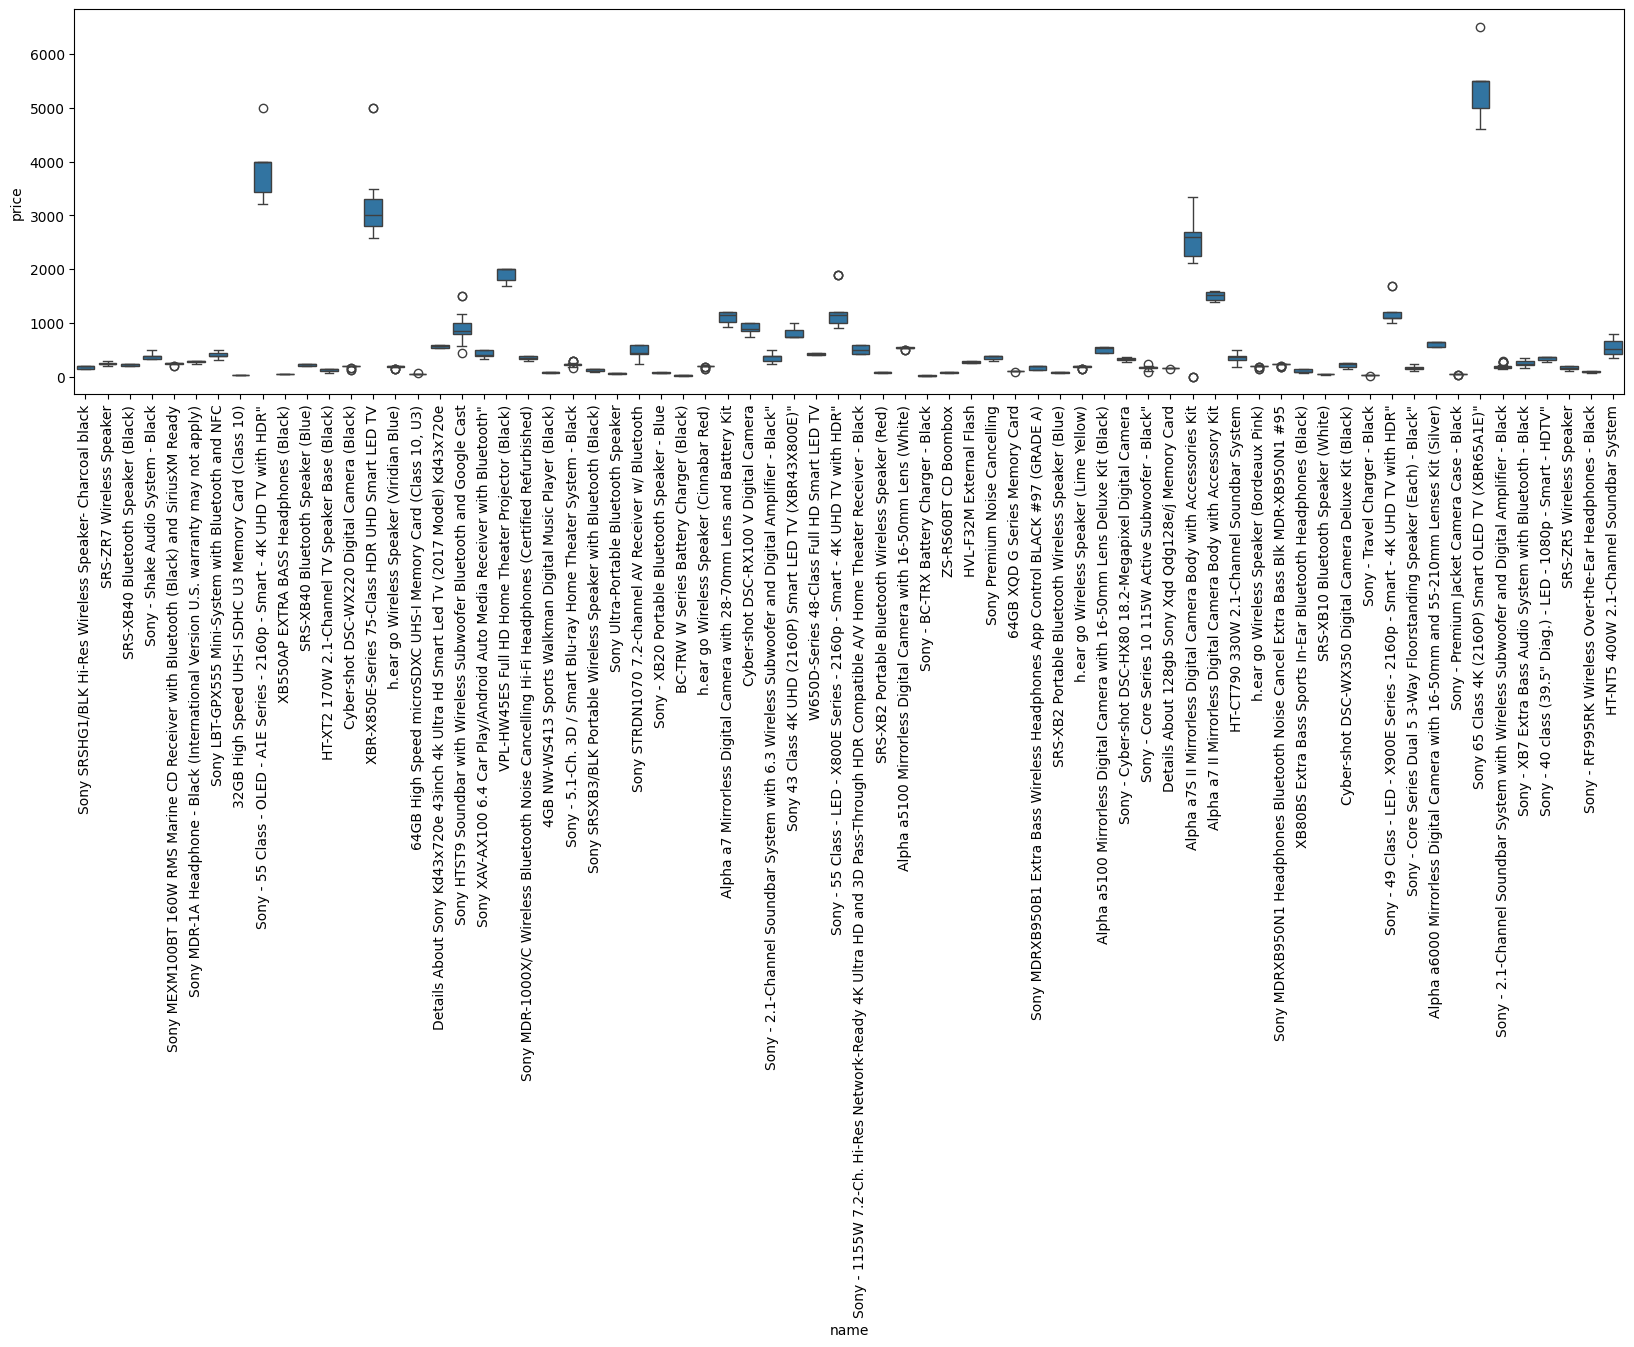

In [19]:
aux = df3.loc[(df3['merchant'] == 'Bestbuy.com') & (df3['brand'] == 'Sony'), ['brand', 'price','name']]

plt.figure(figsize=(20,5))
sns.boxplot(x='name', y='price', data = aux)
plt.xticks(rotation = 90);

In [20]:
# aux[aux['name'] == 'Alpha a7S II Mirrorless Digital Camera Body with Accessories Kit'].sort_values(by='price', ascending = False)

In [21]:
# aux[aux['name'] == 'Sony - 55 Class - OLED - A1E Series - 2160p - Smart - 4K UHD TV with HDR"'].sort_values(by='price', ascending = False)
# aux[aux['name'] == 'XBR-X850E-Series 75-Class HDR UHD Smart LED TV'].sort_values(by='price', ascending = False)

## 3.5 Produto

/home/tiagobarreto/.pyenv/versions/3.11.4/envs/elasticidade/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 130 (\x82) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/home/tiagobarreto/.pyenv/versions/3.11.4/envs/elasticidade/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 130 (\x82) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


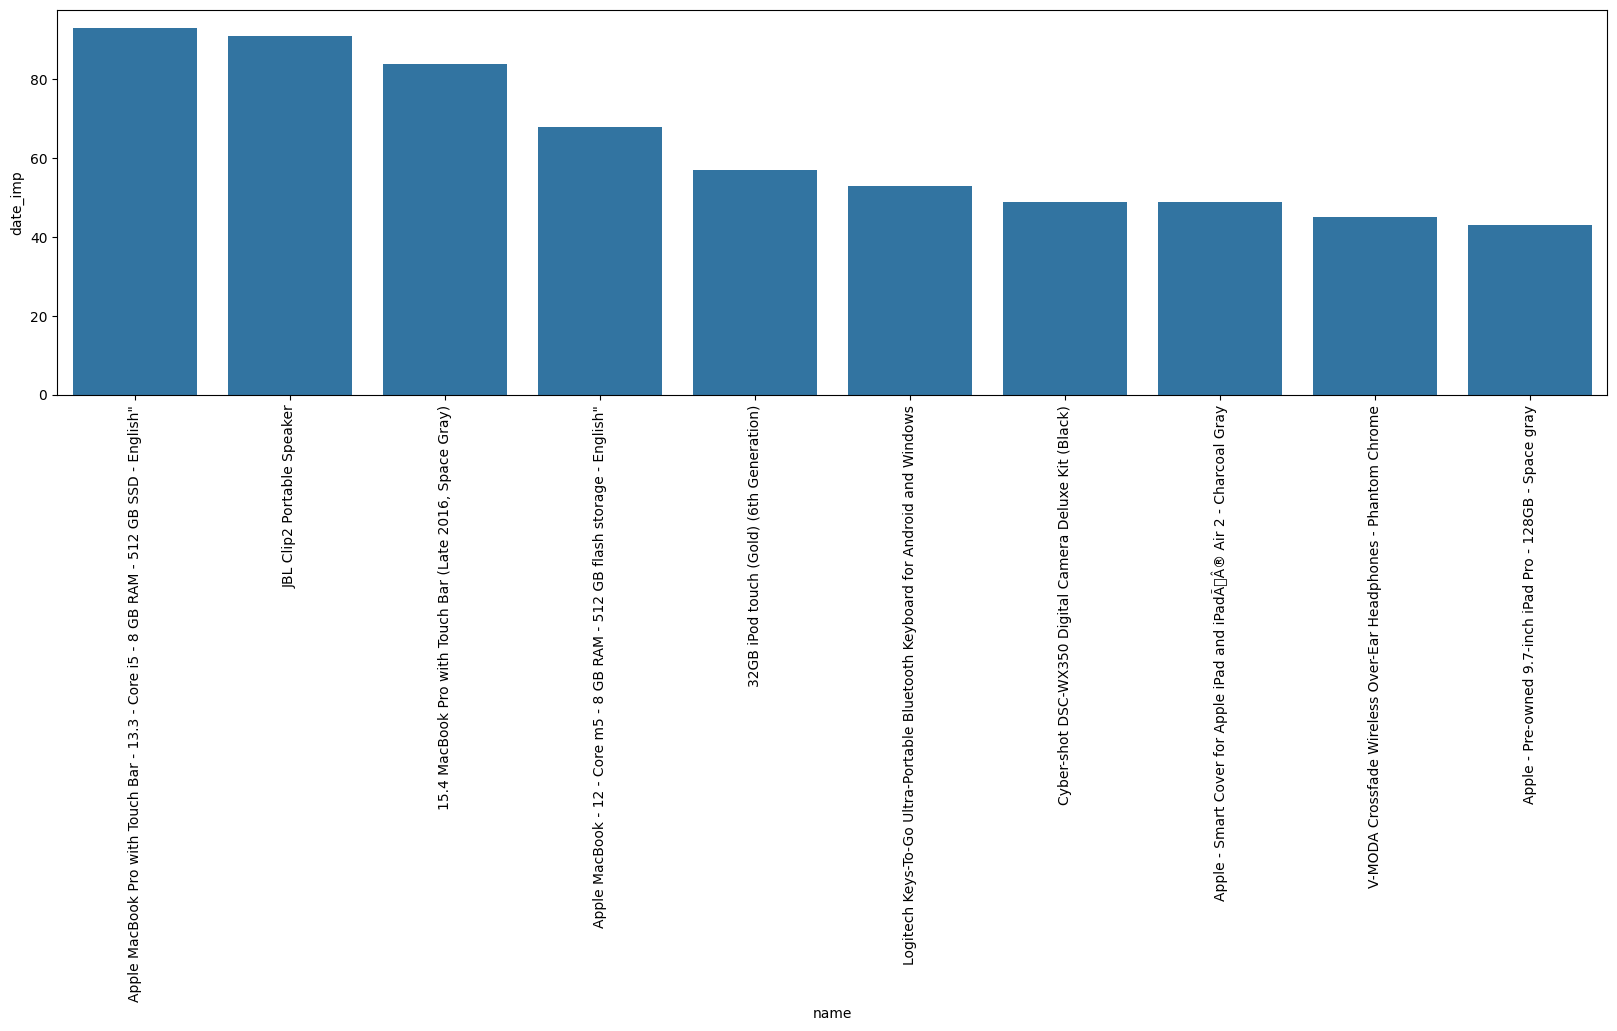

In [22]:
plt.figure(figsize=(20, 5))
df_aux = df3.loc[df3['merchant'] == 'Bestbuy.com' , ['name', 'date_imp']].groupby('name').count().sort_values(by='date_imp', ascending = False).head(10).reset_index()
sns.barplot(x='name', y='date_imp', data = df_aux)
plt.xticks(rotation = 90);

## 3.6 Conclusões
- Filtrar por transações a partir do mês 05-2017.
- Filtrar merchant Bestbuy.com
- Filtrar preço acima de $5.00 para remover os outliers encontrados na Apple e Sony, marcas com maior demanda